In [335]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys
sys.path.append('../../code/')
sys.path.append('/Users/ssulheim/git/mwf_gems/code/python')
import leakage_reframed
import ng_utils
import leakage
import reframed
import scipy
import statsmodels.api as sm


# Ecoli

In [336]:
exometabolites_folder = Path("../../data/e_coli/")
organism = 'e_coli'
fn_OD = exometabolites_folder / "{0}_OD.csv".format(organism)

In [337]:
gDW_per_OD = 0.32

In [338]:
concentrations, concentrations_std = leakage.get_concentrations(exometabolites_folder, 'e_coli')

In [339]:
fn_glucose = exometabolites_folder / "{0}_glucose.csv".format(organism)
glucose_df = pd.read_csv(fn_glucose)

## Remove outliers

In [340]:
concentrations.loc[1, 'FUM'] = np.nan

In [341]:
df_OD = pd.read_csv(fn_OD, index_col=0)
# Assume that OD std is not correlated with OD (see plot below for support of this assumption)
df_OD.fillna(df_OD['OD std'].mean())

,OD mean,OD std
Time,,
0,0.500,0.116168
1,0.514,0.116168
2,0.608,0.116168
3,0.817,0.116168
4,1.595,0.049497
5,2.295,0.190919
6,5.085,0.035355
7,8.765,0.106066
8,13.300,0.056569


## No clear correlation between OD and OD std

Text(0, 0.5, 'std(OD600)')

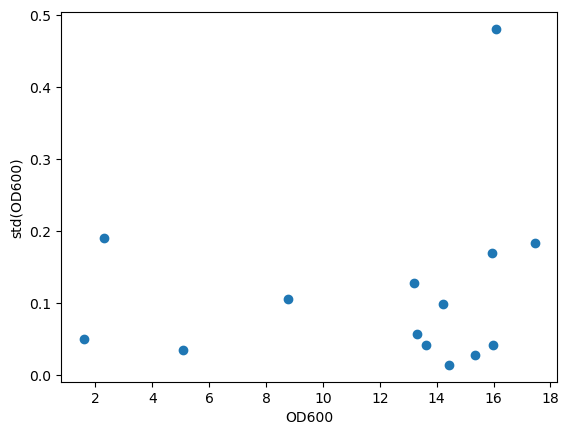

In [342]:
plt.scatter(df_OD['OD mean'], df_OD['OD std'])
plt.xlabel('OD600')
plt.ylabel('std(OD600)')

Text(0, 0.5, 'ln(OD600)')

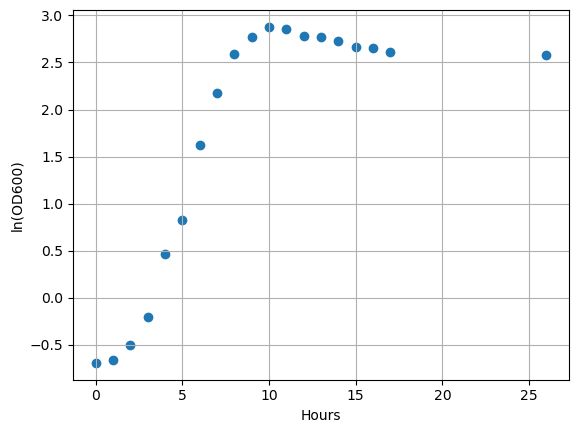

In [343]:
plt.scatter(df_OD.index, np.log(df_OD['OD mean']))
plt.grid()
plt.xlabel('Hours')
plt.ylabel('ln(OD600)')

Text(0, 0.5, 'ln(OD600)')

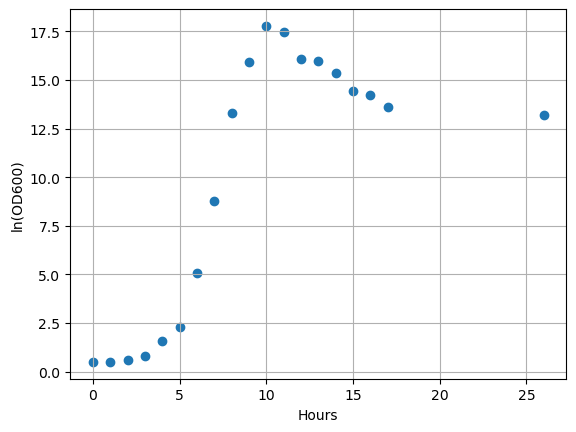

In [344]:
plt.scatter(df_OD.index, df_OD['OD mean'])
plt.grid()
plt.xlabel('Hours')
plt.ylabel('ln(OD600)')

## Mapping

In [345]:
mapping_df = pd.read_csv('../../data/id_mapping.csv', index_col=0)
# mapping_df.index = [x.strip('\t').replace(" MS", "") for x in mapping_df.index]
met_abrv_to_id = mapping_df['Ecoli metabolite'].to_dict()
met_abrv_to_name = mapping_df['Metabolite name'].to_dict()


# Estimate rates

In [346]:
df_OD

,OD mean,OD std
Time,,
0,0.500,NaN
1,0.514,NaN
2,0.608,NaN
3,0.817,NaN
4,1.595,0.049497
5,2.295,0.190919
6,5.085,0.035355
7,8.765,0.106066
8,13.300,0.056569


## Simpson integration

In [377]:
xt = np.zeros(len(df_OD)-1)
for i in range(1, len(df_OD)-1):
    xt[i] = scipy.integrate.simpson(df_OD.loc[:i, 'OD mean'].values, x = df_OD.index[:i+1])
    # xt[i] = np.trapz(df_OD.loc[:i, 'OD mean'], dx=1)
    print(i, df_OD.loc[i, 'OD mean'], xt[i]*gDW_per_OD)

1 0.514 0.16224
2 0.608 0.3374933333333333
3 0.817 0.5645600000000001
4 1.595 0.9210666666666666
5 2.295 1.5597866666666664
6 5.085 2.6127999999999996
7 8.765 4.87712
8 13.3 8.313600000000001
9 15.94 13.113653333333332
10 17.78 18.429866666666666
11 17.45 24.224853333333336
12 16.1 29.48906666666667
13 15.99 34.72138666666666
14 15.34 39.66506666666667
15 14.43 44.518719999999995
16 14.21 48.973866666666666
17 13.61 53.54405333333333


## Trapezoidial rule

In [378]:
# xt = np.zeros(len(df_OD)-1)
# for i in range(1, len(df_OD)-1):
    
#     xt[i] = np.trapz(df_OD.loc[:i, 'OD mean'], dx=1)
#     print(i, df_OD.loc[i, 'OD mean'], xt[i]*gDW_per_OD)

In [379]:
x = pd.Series(xt*gDW_per_OD, index = df_OD.index[:-1])


Text(0, 0.5, 'Cumulative gDW')

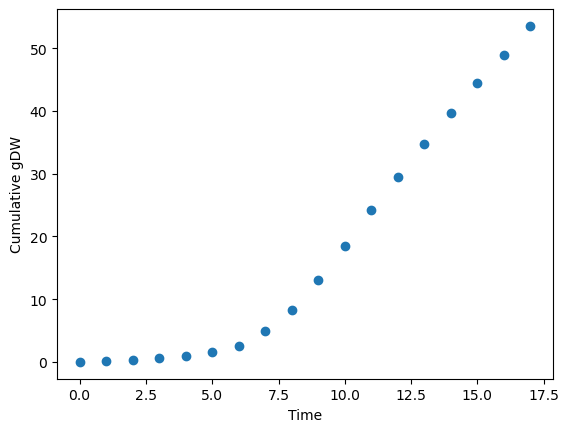

In [380]:
plt.scatter(df_OD.index[:-1], x)
plt.xlabel('Time')
plt.ylabel('Cumulative gDW')

# Fit with custom limits

In [381]:
specific_limits = {
    'G6P': (1, 10),
    'F6P': (1, 10),
    'FBP': (7, 10),
    'DHAP': (1, 10),
    'GA3P': (1, 10),
    '23PG': (1, 10),
    'PEP': (3, 10),
    'R5P': (1, 10),
    'RU5P+X5P': (3, 10),
    'E4P': (6, 10),
    'CIT': (1, 10),
    'ACN': (1, 10),
    'ICIT': (1, 10),
    'OAS': (1, 7),
    'GLU': (1, 10),
    'SER': (1, 10),
    'ASP': (1, 10),
    'THR': (1, 10),
    'HOM': (1, 10),
    'TYR': (1, 10),
    'GLY': (1, 10),
    'PRO': (1, 8),
    'ALA': (1, 9),
    'MET': (1, 9),
    'VAL': (1, 9),
    'PHE': (1, 10),
    'ILEU': (1, 10),
    'LEU': (1, 10),
    'TRP': (1, 6),
    'HIS': (1, 6),
    'ARG': (1, 7),
    'PYR': (1, 8),
    'ORO': (1, 8),
    'FUM': (3, 8),
    'URA': (1, 10),
    'AKG': (7, 10),
    'ACT': (1, 8)
    # 'OAS':5,
    # 'TYR':7,
    # 'PRO':6,
}

In [382]:
# X = sm.add_constant(x[idx])
# mod = sm.OLS(conc[idx],X)
# fii = mod.fit()
# tbl = fii.summary2().tables[1].T[0]
# tbl['Metabolite'] = conc.name
# pd.DataFrame([tbl])
# p_values = fii.summary2().tables[1]['P>|t|']

R-squared: 0.957780
R-squared: 0.970377
R-squared: 0.962600
R-squared: 0.990707
R-squared: 0.991572
R-squared: 0.990443
R-squared: 0.961793
R-squared: 0.966261
R-squared: 0.985878
R-squared: 0.973079
R-squared: 0.958926
R-squared: 0.948878
R-squared: 0.990011
R-squared: 0.879669
R-squared: 0.000087
R-squared: 0.737320
R-squared: 0.981333
R-squared: 0.969000
R-squared: 0.984567
R-squared: 0.962907
R-squared: 0.330372
R-squared: 0.877587
R-squared: 0.914919
R-squared: 0.966786
R-squared: 0.974996
R-squared: 0.942891
R-squared: 0.985311
R-squared: 0.975789
R-squared: 0.983283
R-squared: 0.835639
R-squared: 0.944014
R-squared: 0.987284
R-squared: 0.972688
R-squared: 0.907209
R-squared: 0.734813
R-squared: 0.861127
R-squared: 0.919306


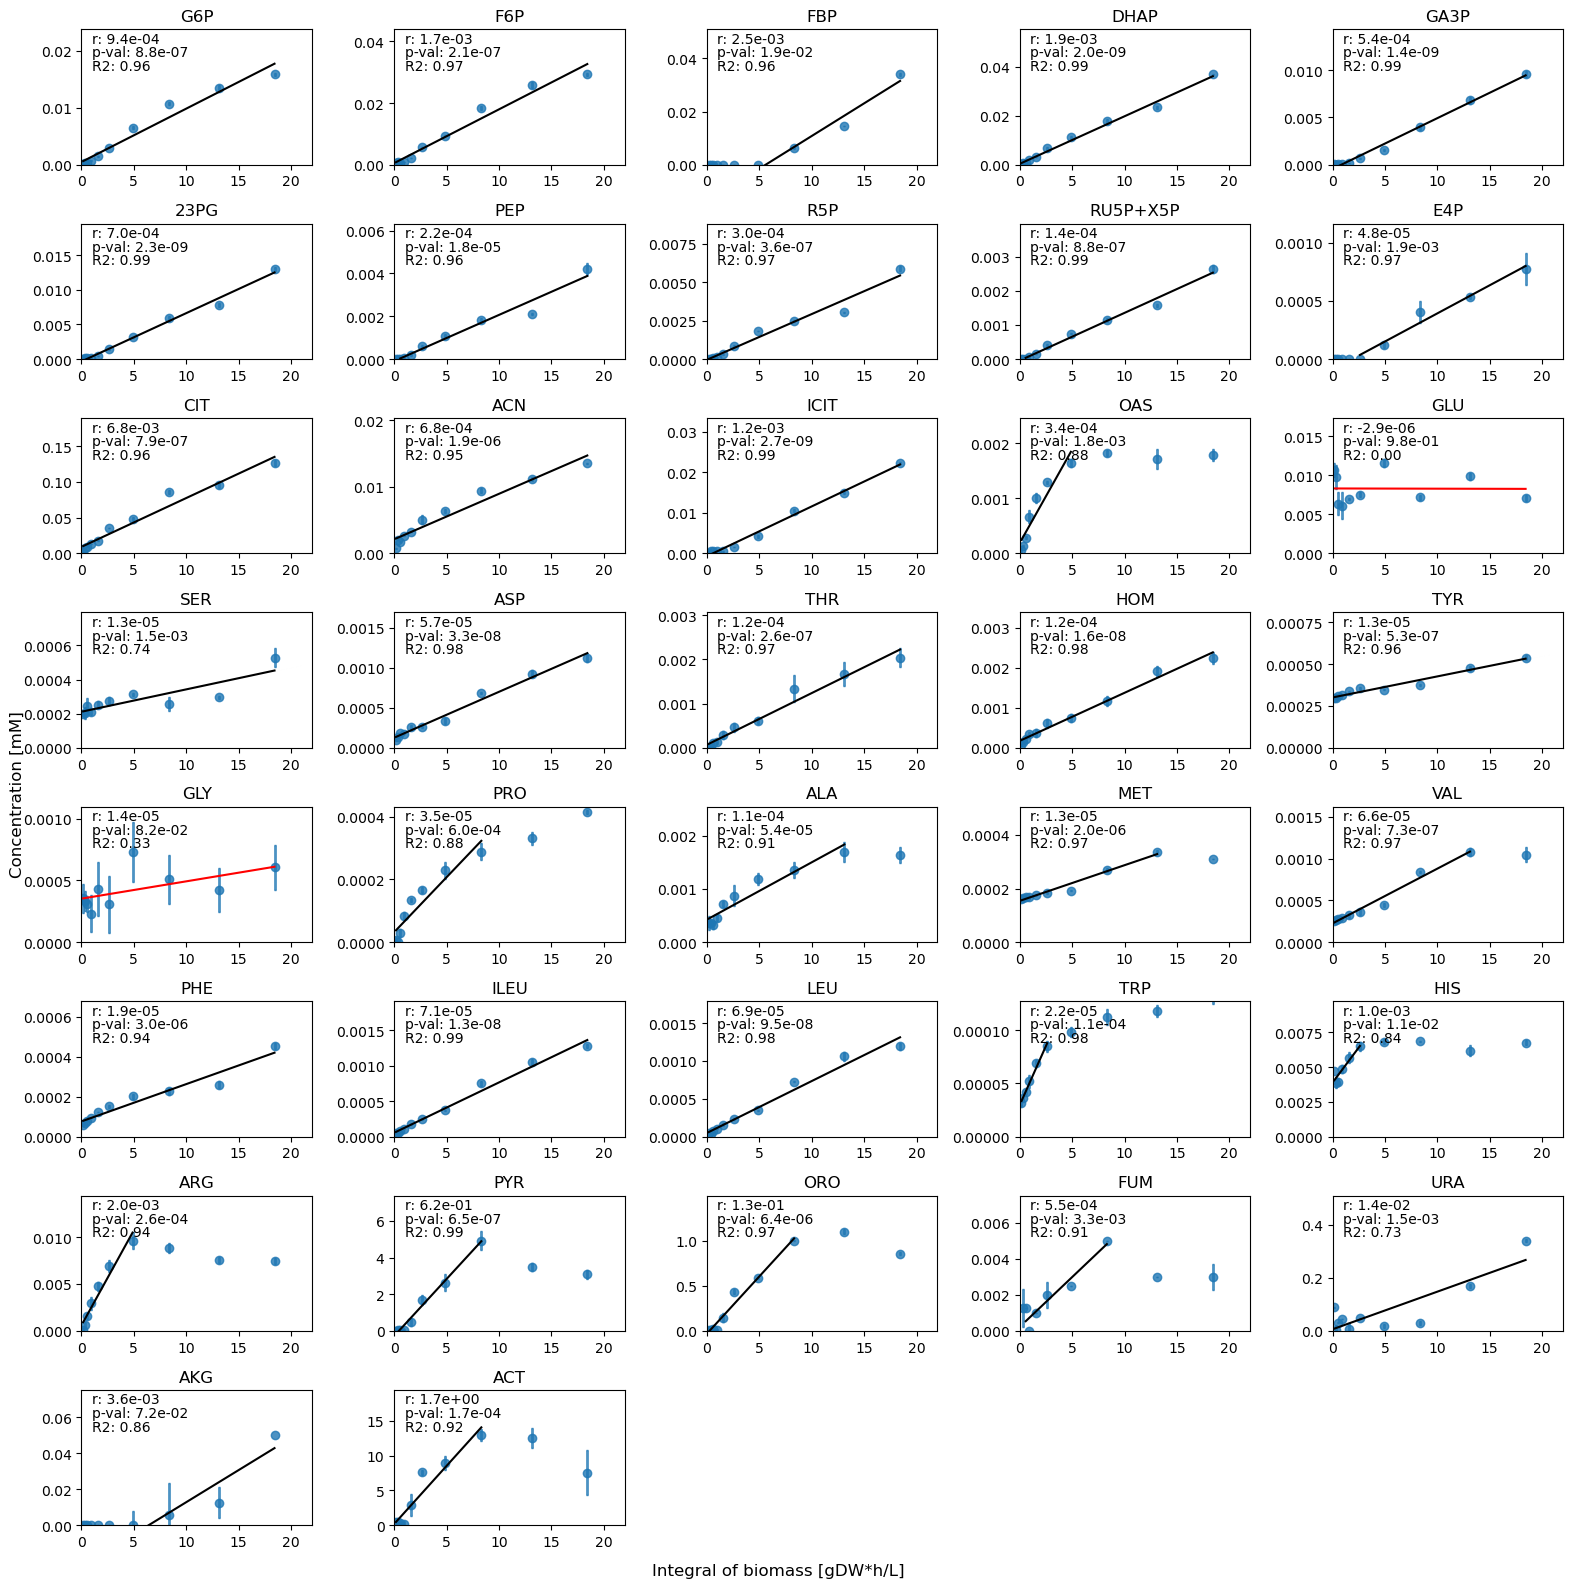

In [405]:
rate_dict_m = {}
fig, axes = plt.subplots(8,5, figsize = (16, 16), sharex = False)
axes = axes.flatten()
fun = lambda x, a ,b: x*a+b
data_list = []
for i,c in enumerate(concentrations.columns):
    # print(c)
    conc = concentrations[c][:-1]*1e-3 # Convert from uM to mM #
    conc_std = concentrations_std[c][:-1]*1e-3
    lim = specific_limits[c]
    idx = ((concentrations.index >= lim[0]) & (concentrations.index <= lim[1]))[:-1]
    rate_conc = conc[idx]
    if np.sum(rate_conc == 0) > 1:
        print(c, 'More than 1 zero')
    # conc[conc==0] = np.nan
    res = scipy.stats.linregress(x[idx], conc[idx])
    print(f"R-squared: {res.rvalue**2:.6f}")
    r2 = res.rvalue**2
    
    # fit, cov, _,_,_ = scipy.optimize.curve_fit(fun, x[idx],
    #                                            conc[idx], full_output=True)
    # rate = fit[0]
    # std_err = np.sqrt(np.diag(cov))[0]
    # t_score = fit[0]/std_err
    # n_df = np.sum(idx)-2
    # p_val = scipy.stats.t.sf(t_score, df = n_df)*2 # *2 is to get two-sided
    # data = [rate, std_err, t_score, n_df, p_val, c, p_val < 0.05]
    data = [res.slope, res.stderr,res.pvalue, c, res.pvalue < 0.05, r2]
    data_list.append(data)
    # rate_dict_m[c] = fit[0]
    # print(fit)
    x_fit = np.linspace(x[idx].min(), x[idx].max(), 3)
    y_fit = fun(x_fit, res.slope, res.intercept)
    ax = axes[i]
    # ax.scatter(x, conc)
    # ax.scatter(x, conc)
    ax.errorbar(x, conc, yerr = conc_std, fmt='o',color='C0',capthick=1,elinewidth=2,capsize=1, zorder = 0, alpha = 0.8)
    if r2 > 0.5:
        ax.plot(x_fit, y_fit, 'k')
    else:
        ax.plot(x_fit, y_fit, 'r')
    ax.set_title(c, )
    ax.set_xlim(0, 22)
    y_max = np.max(conc[idx])*1.5
    ax.set_ylim(0, y_max)
    ax.annotate(f'r: {res.slope:.1e}', (1, y_max*0.9))
    ax.annotate(f'p-val: {res.pvalue:.1e}', (1, y_max*0.8))
    ax.annotate(f'R2: {r2:.2f}', (1, y_max*0.7))
    i +=1
    # print(i)

while i<(8*5):
    axes[i].set_visible(False)
    i+=1

fig.supxlabel('Integral of biomass [gDW*h/L]')
fig.supylabel('Concentration [mM]')

plt.tight_layout()
plt.savefig('ecoli_fitted_rates_manual_limits.png', dpi = 400)
plt.show()

In [384]:
rate_data = pd.DataFrame(data_list, columns = ['Rate [mmol/gDW/h]', 'Std.Err [mmol/gDW/h]', 'p-val', 'Metabolite abbrv.', 'Significance', 'R2'])

In [385]:
rate_data #res.stderr,res.pvalue, c, p_val < 0.05, r2

,Rate [mmol/gDW/h],Std.Err [mmol/gDW/h],p-val,Metabolite abbrv.,Significance,R2
0,0.000938,6.959879e-05,8.839165e-07,G6P,True,0.957780
1,0.001745,1.077798e-04,2.130933e-07,F6P,True,0.970377
2,0.002457,3.424595e-04,1.887838e-02,FBP,True,0.962600
3,0.001943,6.654462e-05,2.047014e-09,DHAP,True,0.990707
4,0.000538,1.754157e-05,1.383984e-09,GA3P,True,0.991572
5,0.000698,2.423577e-05,2.289958e-09,23PG,True,0.990443
6,0.000216,1.755424e-05,1.768515e-05,PEP,True,0.961793
7,0.000298,1.968485e-05,3.591772e-07,R5P,True,0.966261
8,0.000140,6.842439e-06,8.848587e-07,RU5P+X5P,True,0.985878
9,0.000048,4.636291e-06,1.890085e-03,E4P,True,0.973079


## Fit with automatic limits

/Users/ssulheim/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


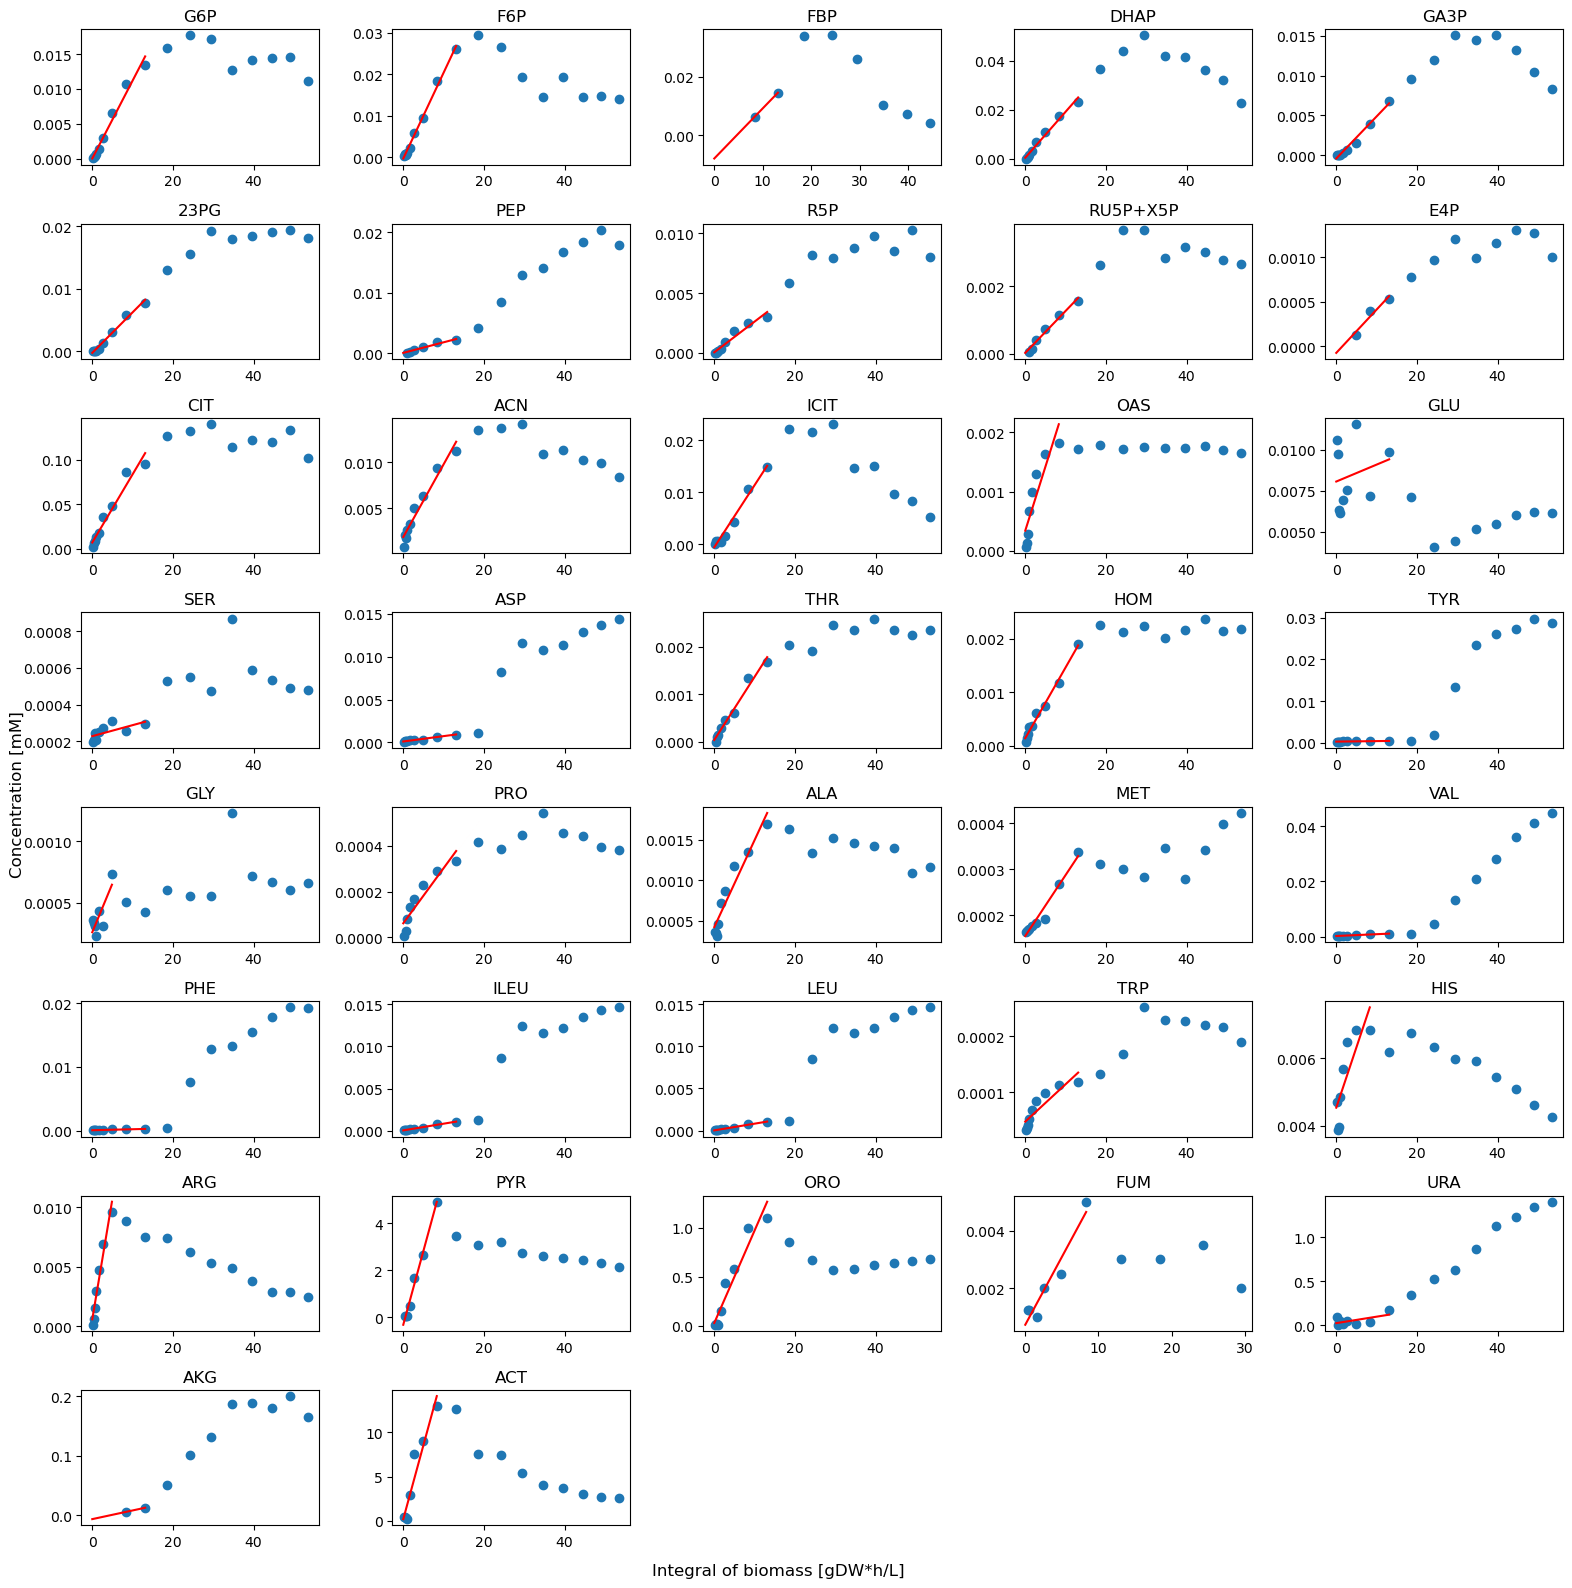

In [386]:
rate_dict = {}
fig, axes = plt.subplots(8,5, figsize = (16, 16), sharex = False)
axes = axes.flatten()
fun = lambda x, a ,b: x*a+b
for i,c in enumerate(concentrations.columns):
    conc = concentrations[c][:-1]*1e-3
    conc[conc==0] = np.nan
    nan_idx = ~np.isnan(conc)
    time_idx = x.index < 10
    if np.sum(nan_idx&time_idx) == 1:
        conc[0] = 0
        nan_idx[0] = True
        
    # print(conc[nan_idx&time_idx])
    rate_conc = conc[nan_idx&time_idx]
    selection = np.ones(len(conc)).astype(bool)
    if (7 in rate_conc.index) and (8 in rate_conc.index) and (9 in rate_conc.index):
        if rate_conc[9] < rate_conc[8]:
            selection[9] = False
            if rate_conc[8] < rate_conc[7]:
                selection[8] = False
                if rate_conc[7] < rate_conc[6]:
                    selection[7] = False
    # print(selection, rate_conc, rate_conc.index)
    # print(c)
    # print(conc[nan_idx&time_idx])
    fit, cov, _,_,_ = scipy.optimize.curve_fit(fun, x[nan_idx&time_idx&selection],
                                               conc[nan_idx&time_idx&selection], full_output=True)
    rate_dict[c] = fit[0]

    # print(fit)
    x_fit = np.linspace(0, x[nan_idx&time_idx&selection].max(), 3)
    y_fit = fun(x_fit, *fit)
    ax = axes[i]
    # ax.scatter(x, conc)
    ax.scatter(x, conc)
    ax.plot(x_fit, y_fit, 'r')
    ax.set_title(c, )

i +=1
# print(i)
while i<(8*5):
    axes[i].set_visible(False)
    i+=1

fig.supxlabel('Integral of biomass [gDW*h/L]')
fig.supylabel('Concentration [mM]')

plt.tight_layout()
plt.savefig('ecoli_fitted_rates.png', dpi = 400)
plt.show()


# Glucose uptake rates

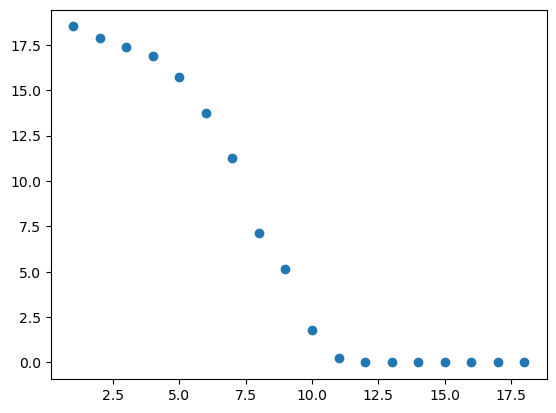

In [387]:
plt.scatter(glucose_df.index, glucose_df['Glucose mean'])

In [388]:
glucose_df

,Time,Glucose mean,Glucose std
0,0,NaN,NaN
1,1,18.5050,24.748737
2,2,17.8950,17.677670
3,3,17.3950,9.192388
4,4,16.9000,21.213203
5,5,15.7000,43.840620
6,6,13.7500,8.768124
7,7,11.2340,5.939697
8,8,7.1560,2.262742
9,9,5.1680,NaN


In [389]:
glucose_df['Glucose mean'][1:n]

1    18.505
2    17.895
3    17.395
4    16.900
5    15.700
6    13.750
7    11.234
Name: Glucose mean, dtype: float64

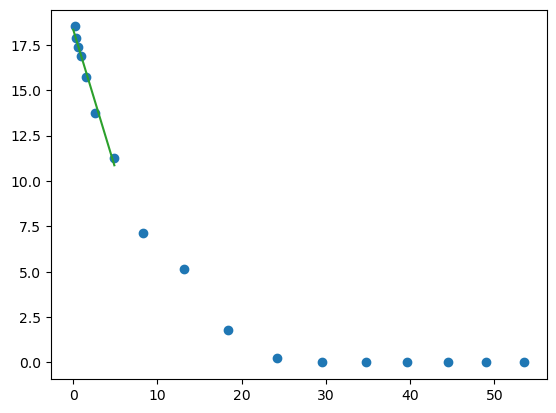

In [390]:
n = 8
fit, cov, _,_,_ = scipy.optimize.curve_fit(fun, x[1:n], glucose_df['Glucose mean'][1:n], full_output=True)
rate = fit[0]
std_err = np.sqrt(np.diag(cov))[0]
t_score = fit[0]/std_err
n_df = np.sum(idx)-2
p_val = scipy.stats.t.sf(t_score, df = n_df)*2 # *2 is to get two-sided
data = [rate, std_err, t_score, n_df, p_val, c, p_val < 0.05]
x_fit = np.linspace(0, x[7], 3)
y_fit = fun(x_fit, *fit)
plt.plot(x_fit, y_fit, c = 'C2')
plt.scatter(x, glucose_df['Glucose mean'][:-1])


In [391]:
glc_mw = 180.156
glc_uptake = fit[0]/glc_mw*1e3 # Converting from g/gDW/h to mmol/gDW/h

In [392]:
glc_uptake

-8.49433004424902

# Get model

In [393]:
model_ez = reframed.load_cbmodel('../../models/e_coli/momentiJO1366.xml')
model_ez.solver = 'gurobi'

In [394]:
reframed.FBA(model_ez)

Objective: 0.742975386519784
Status: Optimal

In [395]:
measured_metabolites = []
for bigg_id in met_abrv_to_id.values():
    if not isinstance(bigg_id, str):
        continue
    m_ids = bigg_id.split(', ')
    for m_id in m_ids:
        if f'M_{m_id}_c' in model_ez.metabolites:
            measured_metabolites.append(f'M_{m_id}_c')

In [396]:
r = model_ez.reactions['R_F6PA_TG_forward']


In [397]:
r.set_flux_bounds(0,0)

# Shadow prices

In [398]:
shadow_prices = leakage_reframed.estimate_shadow_prices(model_ez, constraints={'R_EX_glc__D_e': (glc_uptake,0)}, metabolites = measured_metabolites)

# Turnover

In [399]:
solution = reframed.pFBA(model_ez, constraints={'R_EX_glc__D_e': (glc_uptake,0)})
turnover = solution.get_metabolites_turnover(model_ez)

    

In [400]:
# The turnover of fdp is 0 because the model predicts that F6PA is used instead of FBA . Unlikely, e.g. https://bmcsystbiol.biomedcentral.com/articles/10.1186/1752-0509-7-33

solution.show_metabolite_balance('M_fdp_c', model_ez)

[ --> o ] R_PFK         3.14937  
[ o --> ] R_FBA_TG_forward -3.14937  


# Make spreadsheet

In [401]:
data = []
drop_mets = ['ru5p__L','xu5p__L'] # The L-forms is used in the pentose phosphate pathway, so we assume that it is primarily the D-forms
# 'Std.Err [mmol/gDW/h]', 'T-score', 'degrees of freedom', 'p-val', 'Metabolite abbrv.', 'Significance']
for _, row in rate_data.iterrows():
    if row['R2']<0.5:
        continue
    abbr = row['Metabolite abbrv.']
    rate = row['Rate [mmol/gDW/h]']
    bigg_ids = [x.strip() for x in met_abrv_to_id[abbr].split(',') if not x.strip() in drop_mets]
    if len(bigg_ids)>1:
        print(bigg_ids)
    rate_i = rate/len(bigg_ids)
    std_err_i = row['Std.Err [mmol/gDW/h]']/np.sqrt(len(bigg_ids))
    for bigg_id in bigg_ids:
        name =met_abrv_to_name[abbr]
        m_id = f'M_{bigg_id}_c'
        mv = -shadow_prices[m_id]
        m = model_ez.metabolites[m_id]
        element_dict = ng_utils.get_element_dict(m)
        Nc = element_dict['C']
        mass = ng_utils.get_mol_weight(m)
        
        data.append([abbr, bigg_id, name, mv, turnover[m_id], Nc, mass, rate_i, std_err_i, row['R2']])
df_rate = pd.DataFrame(data, columns = ['Metabolite abbrv.', 'BiGG ID', 'Metabolite', 
                                        'Metabolite value [gDW/mmol]', 'Turnover [mmol/gDW/h]', 'N carbons', 
                                        'Mol weight [g/mol]', 'Rate [mmol/gDW/h]', 'Std.Err [mmol/gDW/h]', 'R2'])

['2pg', '3pg']
['ru5p__D', 'xu5p__D']


In [402]:
df_rate['Species'] = 'E. coli'
df_rate['Carbon source'] = 'Glucose'
df_rate['Dataset'] = 'Paczia-13'

In [403]:
df_rate.to_csv('paczia_13_rates_ecoli_130524.csv')

In [374]:
df_rate

,Metabolite abbrv.,BiGG ID,Metabolite,Metabolite value [gDW/mmol],Turnover [mmol/gDW/h],N carbons,Mol weight [g/mol],Rate [mmol/gDW/h],Std.Err [mmol/gDW/h],R2,Species,Carbon source,Dataset
0,G6P,g6p,Glucose-6-phosphate,0.040475,8.291959,6,258.119901,0.000938,6.959879e-05,0.957780,E. coli,Glucose,Paczia-13
1,F6P,f6p,Fructose-6-phosphate,0.040539,4.546529,6,258.119901,0.001745,1.077798e-04,0.970377,E. coli,Glucose,Paczia-13
2,FBP,fdp,"Fructose-1,6-bisphosphate",0.047525,4.483283,6,336.083922,0.002457,3.424595e-04,0.962600,E. coli,Glucose,Paczia-13
3,DHAP,dhap,Dihydroxyacetonephosphate,0.024921,4.483283,3,168.041961,0.001943,6.654462e-05,0.990707,E. coli,Glucose,Paczia-13
4,GA3P,g3p,Glyceraldehyde-3-phosphate,0.024923,12.003921,3,168.041961,0.000538,1.754157e-05,0.991572,E. coli,Glucose,Paczia-13
5,23PG,2pg,2/3-phosphoglycerate,0.018480,11.746767,3,183.033421,0.000349,1.713728e-05,0.990443,E. coli,Glucose,Paczia-13
6,23PG,3pg,2/3-phosphoglycerate,0.018396,11.746767,3,183.033421,0.000349,1.713728e-05,0.990443,E. coli,Glucose,Paczia-13
7,PEP,pep,Phosphoenolpyruvate,0.019329,11.746767,3,165.018141,0.000216,1.755424e-05,0.961793,E. coli,Glucose,Paczia-13
8,R5P,r5p,Ribose-5-phosphate,0.034235,0.880150,5,228.093921,0.000298,1.968485e-05,0.966261,E. coli,Glucose,Paczia-13
9,RU5P+X5P,ru5p__D,Ribu-/Xylulose-5-phosphate,0.033890,1.162050,5,228.093921,0.000070,4.838335e-06,0.985878,E. coli,Glucose,Paczia-13
